In [1]:
import pandas as pd
import dask.dataframe as dd

In [2]:
# Load the data
row_df = dd.read_csv("../data/100_15_2021.csv.gz").compute()
row_df.head()

/home/soo/git_repos/datahackdays_2024/.venv/lib/python3.10/site-packages/dask/dataframe/io/csv.py:555: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(


,id,timestamp,value_kwh,year
0,f75148515d279e2c6c36207fa4002faf,2021-05-08T00:15:00.000Z,0.0,2021
1,f75148515d279e2c6c36207fa4002faf,2021-01-30T06:30:00.000Z,0.0,2021
2,f75148515d279e2c6c36207fa4002faf,2021-01-25T23:15:00.000Z,0.0,2021
3,f75148515d279e2c6c36207fa4002faf,2021-02-03T18:30:00.000Z,0.0,2021
4,f75148515d279e2c6c36207fa4002faf,2021-06-17T19:15:00.000Z,0.0,2021


In [6]:
# Add year_month column
sample_df = row_df
sample_df["timestamp"] = pd.to_datetime(sample_df["timestamp"])
sample_df["year_month"] = sample_df["timestamp"].dt.to_period("M")

# Add hour of day column
sample_df["hour"] = sample_df["timestamp"].dt.hour
# Add quarter hour column
sample_df["quarter_hour"] = sample_df["timestamp"].dt.minute // 15
sample_df.head()

/tmp/ipykernel_118515/3720452842.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sample_df["year_month"] = sample_df["timestamp"].dt.to_period("M")


,id,timestamp,value_kwh,year,year_month,hour,quarter_hour
0,f75148515d279e2c6c36207fa4002faf,2021-05-08 00:15:00+00:00,0.0,2021,2021-05,0,1
1,f75148515d279e2c6c36207fa4002faf,2021-01-30 06:30:00+00:00,0.0,2021,2021-01,6,2
2,f75148515d279e2c6c36207fa4002faf,2021-01-25 23:15:00+00:00,0.0,2021,2021-01,23,1
3,f75148515d279e2c6c36207fa4002faf,2021-02-03 18:30:00+00:00,0.0,2021,2021-02,18,2
4,f75148515d279e2c6c36207fa4002faf,2021-06-17 19:15:00+00:00,0.0,2021,2021-06,19,1


In [47]:
daily_df = sample_df.groupby(["id","year_month", "hour", "quarter_hour"])["value_kwh"].agg(["mean"]).reset_index()
daily_df.head()
# Rename the column mean to value_kwh
daily_df = daily_df.rename(columns={"mean":"value_kwh"})
# Create a timestampe column
daily_df["timestamp"] = pd.to_datetime(daily_df["year_month"].astype(str) + " " + daily_df["hour"].astype(str) + ":" + (daily_df["quarter_hour"]*15).astype(str) + ":00")
daily_df.head()

/tmp/ipykernel_118515/2089217005.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_df["timestamp"] = pd.to_datetime(daily_df["year_month"].astype(str) + " " + daily_df["hour"].astype(str) + ":" + (daily_df["quarter_hour"]*15).astype(str) + ":00")


,id,year_month,hour,quarter_hour,value_kwh,timestamp
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0,0,0.038613,2021-01-01 00:00:00
1,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0,1,0.035548,2021-01-01 00:15:00
2,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0,2,0.034290,2021-01-01 00:30:00
3,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0,3,0.040903,2021-01-01 00:45:00
4,035293b7f95ace18fc6c574cc4e6cc74,2021-01,1,0,0.039452,2021-01-01 01:00:00


In [51]:
daily_df = sample_df.groupby(["id","year_month", "hour"])["value_kwh"].agg(["mean"]).reset_index()
daily_df.head()
# Rename the column mean to value_kwh
daily_df = daily_df.rename(columns={"mean":"value_kwh"})
# Create a timestampe column
daily_df["timestamp"] = pd.to_datetime(daily_df["year_month"].astype(str) + " " + daily_df["hour"].astype(str) +  ":00:00")
daily_df.head()

/tmp/ipykernel_118515/1888213105.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_df["timestamp"] = pd.to_datetime(daily_df["year_month"].astype(str) + " " + daily_df["hour"].astype(str) +  ":00:00")


,id,year_month,hour,value_kwh,timestamp
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0,0.037339,2021-01-01 00:00:00
1,035293b7f95ace18fc6c574cc4e6cc74,2021-01,1,0.039823,2021-01-01 01:00:00
2,035293b7f95ace18fc6c574cc4e6cc74,2021-01,2,0.038306,2021-01-01 02:00:00
3,035293b7f95ace18fc6c574cc4e6cc74,2021-01,3,0.045460,2021-01-01 03:00:00
4,035293b7f95ace18fc6c574cc4e6cc74,2021-01,4,0.042355,2021-01-01 04:00:00


In [56]:
# Get the ids in the dataset
ids = sample_df["id"].unique()

In [67]:
from statsmodels.tsa.seasonal import STL

# Dictionary to store the results
stl_results = {}

# Iterate over each unique id and year_month
for unique_id in ids:
    for year_month in daily_df['year_month'].unique():
        # Filter the dataframe for the current id and year_month
        id_df = daily_df[(daily_df["id"] == unique_id) & (daily_df["year_month"] == year_month)].reset_index(drop=True)

        # Sort by timestamp
        id_df = id_df.sort_values("timestamp")

        # Perform STL decomposition
        stl = STL(id_df['value_kwh'], seasonal=7, period=4)
        result = stl.fit()

        # Store the results
        stl_results[(unique_id, year_month)] = result.trend


In [78]:
# Load strl_results into a dataframe where the keys are the rows and the values are the columns
stl_df = pd.DataFrame(stl_results).T

In [79]:
stl_df.reset_index(inplace=True)
# Add stl_ prefix to the columns but not the id and year_month columns
stl_df = stl_df.add_prefix("stl_")
# Rename the columns level_0 and level_1 to id and year_month
stl_df = stl_df.rename(columns={"stl_level_0":"id", "stl_level_1":"year_month"})

stl_df.head()

,id,year_month,stl_0,stl_1,stl_2,stl_3,stl_4,stl_5,stl_6,stl_7,...,stl_14,stl_15,stl_16,stl_17,stl_18,stl_19,stl_20,stl_21,stl_22,stl_23
0,f75148515d279e2c6c36207fa4002faf,2021-01,-0.000018,-0.000010,-6.077102e-07,0.000011,0.000024,0.000062,0.000098,0.000115,...,0.000430,0.000468,0.000405,0.000261,0.000112,0.000026,0.000013,0.000003,-0.000001,-0.000002
1,f75148515d279e2c6c36207fa4002faf,2021-02,-0.000004,0.000008,2.741800e-05,0.000052,0.000085,0.000162,0.000211,0.000224,...,0.000226,0.000356,0.000408,0.000379,0.000266,0.000119,0.000079,0.000044,0.000020,0.000009
2,f75148515d279e2c6c36207fa4002faf,2021-03,-0.000060,-0.000017,3.301421e-05,0.000085,0.000146,0.000208,0.000216,0.000179,...,0.000091,0.000224,0.000336,0.000374,0.000340,0.000222,0.000127,0.000046,-0.000029,-0.000092
3,f75148515d279e2c6c36207fa4002faf,2021-04,-0.000119,-0.000037,3.933698e-05,0.000110,0.000167,0.000159,0.000119,0.000055,...,0.000039,0.000148,0.000289,0.000372,0.000385,0.000313,0.000169,0.000044,-0.000082,-0.000205
4,f75148515d279e2c6c36207fa4002faf,2021-05,-0.000100,-0.000035,2.216851e-05,0.000074,0.000113,0.000097,0.000065,0.000024,...,0.000014,0.000105,0.000313,0.000505,0.000597,0.000573,0.000328,0.000091,-0.000157,-0.000418


In [80]:
# Save the results to a csv file
stl_df.to_csv("../features/100_15_2021_stl_features.csv", index=False)

In [ ]:
# Example: Access the seasonal component for a specific id
example_id = ids[0]
seasonal_component = stl_results[example_id]["seasonal"]
trend_component = stl_results[example_id]["trend"]

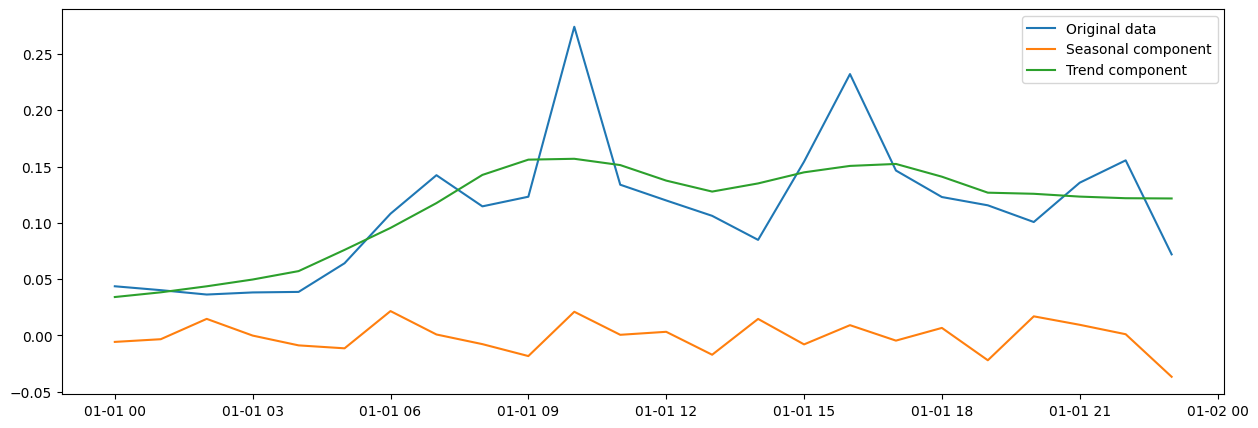

In [52]:


# Plot the seasonal trend and original data
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(id_df["timestamp"], id_df["value_kwh"], label="Original data")
plt.plot(id_df["timestamp"], seasonal_component, label="Seasonal component")
plt.plot(id_df["timestamp"], trend_component, label="Trend component")
plt.legend()
plt.show()

In [53]:
len(result.trend)

24

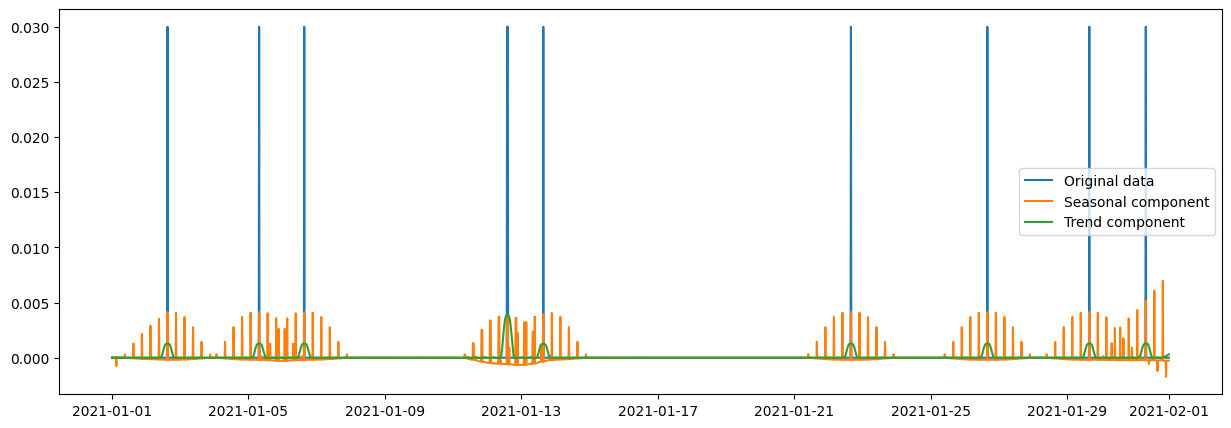

In [57]:
# Add year_month column
sample_df = row_df
sample_df["timestamp"] = pd.to_datetime(sample_df["timestamp"])
sample_df["year_month"] = sample_df["timestamp"].dt.to_period("M")
# Add day of week column
sample_df["day_of_week"] = sample_df["timestamp"].dt.day_name()
# Add week of year column
sample_df["week_of_year"] = sample_df["timestamp"].dt.isocalendar().week
# Add month of year column
sample_df["month_of_year"] = sample_df["timestamp"].dt.month
# Add week of month column by deviding week_of_year by month_of_year
sample_df["week_of_month"] = sample_df["week_of_year"] % sample_df["month_of_year"]
# Get week of month 1-4
sample_df.head(30)

/tmp/ipykernel_65570/2450030782.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sample_df["year_month"] = sample_df["timestamp"].dt.to_period("M")


,id,timestamp,value_kwh,year,year_month,day_of_week,week_of_year,month_of_year,week_of_month
0,f75148515d279e2c6c36207fa4002faf,2021-05-08 00:15:00+00:00,0.0,2021,2021-05,Saturday,18,5,3
1,f75148515d279e2c6c36207fa4002faf,2021-01-30 06:30:00+00:00,0.0,2021,2021-01,Saturday,4,1,0
2,f75148515d279e2c6c36207fa4002faf,2021-01-25 23:15:00+00:00,0.0,2021,2021-01,Monday,4,1,0
3,f75148515d279e2c6c36207fa4002faf,2021-02-03 18:30:00+00:00,0.0,2021,2021-02,Wednesday,5,2,1
4,f75148515d279e2c6c36207fa4002faf,2021-06-17 19:15:00+00:00,0.0,2021,2021-06,Thursday,24,6,0
5,f75148515d279e2c6c36207fa4002faf,2021-03-29 15:45:00+00:00,0.0,2021,2021-03,Monday,13,3,1
6,f75148515d279e2c6c36207fa4002faf,2021-05-31 01:45:00+00:00,0.0,2021,2021-05,Monday,22,5,2
7,f75148515d279e2c6c36207fa4002faf,2021-11-14 12:30:00+00:00,0.0,2021,2021-11,Sunday,45,11,1
8,f75148515d279e2c6c36207fa4002faf,2021-09-07 22:30:00+00:00,0.0,2021,2021-09,Tuesday,36,9,0
9,f75148515d279e2c6c36207fa4002faf,2021-07-13 09:30:00+00:00,0.0,2021,2021-07,Tuesday,28,7,0


In [44]:
# Mean day of week per month
mean_day_of_week_total = (
    sample_df.groupby(["year_month", "day_of_week"])["value_kwh"]
    .agg(["mean", "std"])
    .reset_index()
)
mean_day_of_week_total.rename(
    columns={"mean": "day_mean_total", "std": "day_std_total"}, inplace=True
)
mean_day_of_week_total.head()

,year_month,day_of_week,day_mean_total,day_std_total
0,2021-01,Friday,0.153757,0.303227
1,2021-01,Monday,0.158603,0.301362
2,2021-01,Saturday,0.164239,0.319735
3,2021-01,Sunday,0.152953,0.297869
4,2021-01,Thursday,0.151978,0.299198


In [45]:
# Mean and standard deviation of value_kwh per month
mean_day_of_week_id = (
    sample_df.groupby(["id", "year_month", "day_of_week"])["value_kwh"]
    .agg(["mean", "std"])
    .reset_index()
)
mean_day_of_week_id.rename(columns={"mean": "day_mean_id", "std": "day_std_id"}, inplace=True)
mean_day_of_week_id.head()

,id,year_month,day_of_week,day_mean_id,day_std_id
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Friday,0.049581,0.018778
1,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Monday,0.052521,0.018519
2,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Saturday,0.050671,0.018667
3,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Sunday,0.050542,0.018113
4,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Thursday,0.050247,0.018916


In [46]:
# Join the two dataframes on year_month and day_of_week
mean_day_of_week = mean_day_of_week_id.merge(
    mean_day_of_week_total, on=["year_month", "day_of_week"], how="left"
)
mean_day_of_week.head()

,id,year_month,day_of_week,day_mean_id,day_std_id,day_mean_total,day_std_total
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Friday,0.049581,0.018778,0.153757,0.303227
1,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Monday,0.052521,0.018519,0.158603,0.301362
2,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Saturday,0.050671,0.018667,0.164239,0.319735
3,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Sunday,0.050542,0.018113,0.152953,0.297869
4,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Thursday,0.050247,0.018916,0.151978,0.299198


In [49]:

mean_day_of_week["day_mean_diff"] = (
    mean_day_of_week["day_mean_id"] / mean_day_of_week["day_mean_total"]
)

# Z-score of the mean value_kwh per day of week
# Z-Score formula: (X - μ) / σ
mean_day_of_week["day_mean_zscore"] = (
    mean_day_of_week["day_mean_id"] - mean_day_of_week["day_mean_total"]
) / mean_day_of_week["day_std_id"]
# Drop the columns that are not needed
mean_day_of_week.drop(columns=["day_mean_diff", "day_std_total", "day_mean_total"], inplace=True)
mean_day_of_week.head()

,id,year_month,day_of_week,day_mean_id,day_std_id,day_mean_zscore
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Friday,0.049581,0.018778,-5.547645
1,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Monday,0.052521,0.018519,-5.728123
2,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Saturday,0.050671,0.018667,-6.084058
3,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Sunday,0.050542,0.018113,-5.653950
4,035293b7f95ace18fc6c574cc4e6cc74,2021-01,Thursday,0.050247,0.018916,-5.378075


In [ ]:
# Calculate weekly max and min mean value_kwh
weekly = sample_df.groupby(["id", "year_month", "day_of_week"])["value_kwh"].agg(["mean"])

In [23]:
mean_day_of_week_id = sample_df.groupby(["id", "year_month", "day_of_week"]).agg(
    {"value_kwh": ["mean", "std"]}
)

# Join the two dataframes on year_month
mean_day_of_week_total = mean_day_of_week_total.reset_index()
# Flatten the multi-level column names
mean_day_of_week_total.columns = mean_day_of_week_total.columns.get_level_values(0)

mean_day_of_week_id = mean_day_of_week_id.reset_index()
mean_day_of_week = mean_day_of_week_total.merge(
    mean_day_of_week_id, on=["year_month", "day_of_week"], how="left"
)

mean_day_of_week.head()

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [7]:
# Add monthly features
monthly_features_df = sample_df.groupby(["id", "year_month"]).agg(
    {"value_kwh": ["mean", "std", "min", "max"]}
)

monthly_features_df.columns = ["_".join(col).strip() for col in monthly_features_df.columns.values]
monthly_features_df = monthly_features_df.reset_index()
monthly_features_df.head()

,id,year_month,value_kwh_mean,value_kwh_std,value_kwh_min,value_kwh_max
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0.050968,0.018580,0.0,0.095
1,035293b7f95ace18fc6c574cc4e6cc74,2021-02,0.046885,0.019188,0.0,0.097
2,035293b7f95ace18fc6c574cc4e6cc74,2021-03,0.045167,0.018714,0.0,0.095
3,035293b7f95ace18fc6c574cc4e6cc74,2021-04,0.042099,0.018532,0.0,0.096
4,035293b7f95ace18fc6c574cc4e6cc74,2021-05,0.037923,0.018846,0.0,0.095


In [14]:
# Save the data as csv
monthly_features_df.to_csv("../data/100_15_2021_features.csv", index=False)
monthly_features_df.head()

,id,year_month,value_kwh_mean,value_kwh_std,value_kwh_min,value_kwh_max
0,035293b7f95ace18fc6c574cc4e6cc74,2021-01,0.050968,0.018580,0.0,0.095
1,035293b7f95ace18fc6c574cc4e6cc74,2021-02,0.046885,0.019188,0.0,0.097
2,035293b7f95ace18fc6c574cc4e6cc74,2021-03,0.045167,0.018714,0.0,0.095
3,035293b7f95ace18fc6c574cc4e6cc74,2021-04,0.042099,0.018532,0.0,0.096
4,035293b7f95ace18fc6c574cc4e6cc74,2021-05,0.037923,0.018846,0.0,0.095
